In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

def plot_quantile_compare1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("t(s)")
    plt.plot(x,y,'.',color='c')
    plt.show()
    
def plot_quantile_compare_perf1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            time = float(line.split()[1])
            cost = float(line.split()[2])
            y.append((cost/time)*1e-9)
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    plt.show()

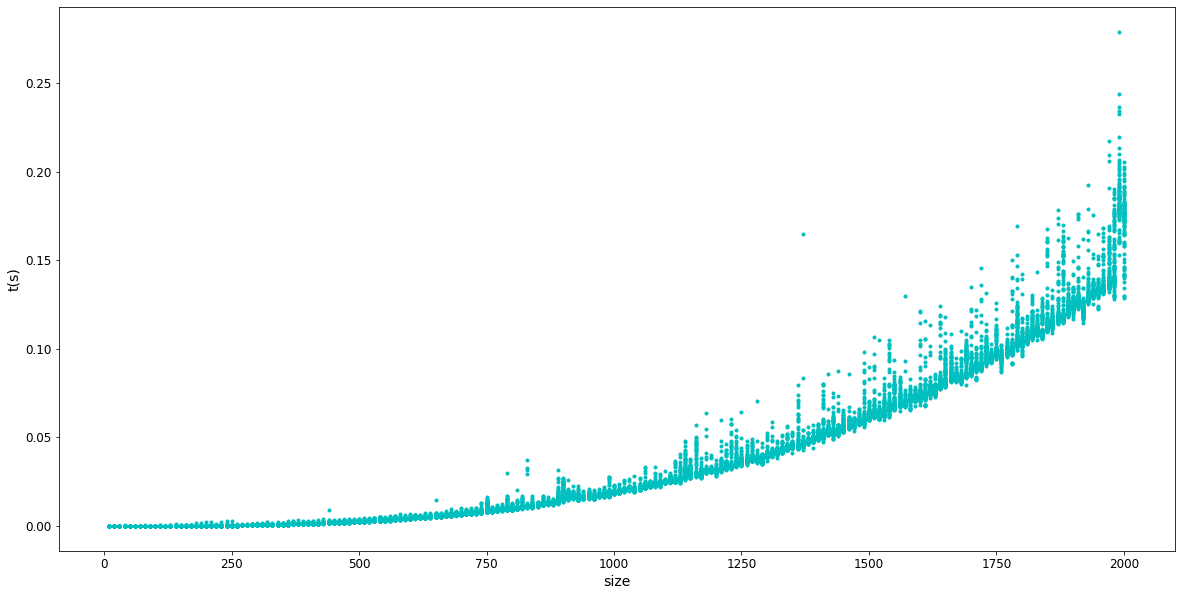

In [4]:
#plt.yscale('log')
plot_quantile_compare1("data/gemm2000.txt")

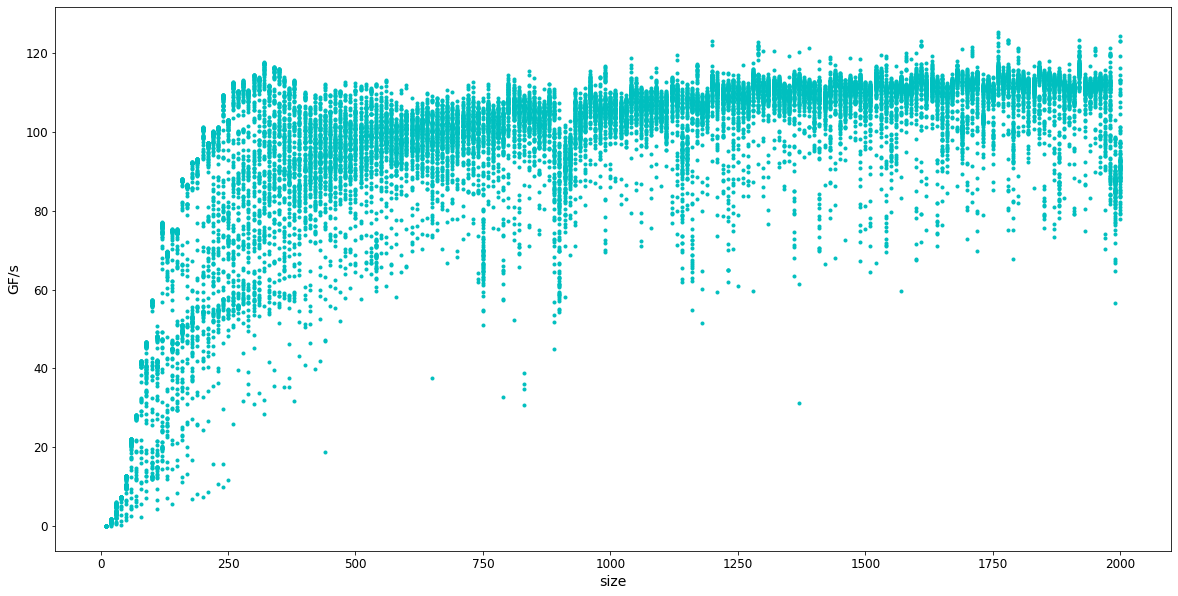

In [5]:
plot_quantile_compare_perf1("data/gemm2000.txt")

### Random seed

In [40]:
tf.random.set_seed(2252)
#tf.random.set_seed(1250) # throws 0's

In [41]:
def cast_to_number(x):
    return tf.strings.to_number(x,out_type=tf.float64)

def split_features_labels(x):
    nn_input = tf.stack([x[0],x[0]**2])
    nn_gt = x[1]*1e4
    return (nn_input, nn_gt[...,tf.newaxis])

filename = "data/gemm2000_shuffled.txt"
ds_file = tf.data.TextLineDataset(filename)
ds_file = ds_file.map(tf.strings.split)
ds_file = ds_file.map(cast_to_number)
ds_file = ds_file.map(split_features_labels)

DATASET_SIZE = len(open(filename).readlines())

train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = ds_file.take(train_size)
train_dataset = train_dataset.batch(5)

test_dataset = ds_file.skip(train_size)
test_dataset = test_dataset.batch(1)

tf.keras.backend.set_floatx('float64')

In [42]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(None,2))
    self.d2 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    self.d3 = tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

In [43]:
model = MyModel()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop(0.001)
mean_loss = tf.keras.metrics.Mean(name='mean_loss')

@tf.function
def train_step(x,gt):
    with tf.GradientTape() as tape:
        nn_out = model(x)
        loss_out = loss(gt, nn_out) 
        reg_loss = tf.math.add_n(model.losses)
        loss_out = loss_out + reg_loss
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    mean_loss(loss_out)
    
def train_model():
    i = 0
    for input_x, gt_y in train_dataset:
        i = i+1
        train_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss.result()))
            mean_loss.reset_states()
            
mean_loss_test = tf.keras.metrics.Mean(name='mean_loss_test')

@tf.function
def test_step(x, gt):
    nn_out = model(x)
    test_loss = loss(gt, nn_out)

    mean_loss_test(test_loss)
    
    return nn_out

def test_model():
    i = 0
    for input_x, gt_y in test_dataset:
        i = i+1
        result = test_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss_test.result()))
            print(input_x.numpy(), result.numpy(), gt_y.numpy())
        mean_loss_test.reset_states()

In [44]:
train_model()

Iter 100, Loss: 10842315.546164012
Iter 200, Loss: 300879.77808257844
Iter 300, Loss: 314286.0757367872
Iter 400, Loss: 311872.6504358074
Iter 500, Loss: 351089.5400262885
Iter 600, Loss: 304500.70276520384
Iter 700, Loss: 358328.66486797197
Iter 800, Loss: 252715.01845631283
Iter 900, Loss: 32274.197021928445
Iter 1000, Loss: 26106.509079230247
Iter 1100, Loss: 17158.478560766092
Iter 1200, Loss: 25186.51490590132
Iter 1300, Loss: 11524.373992586514
Iter 1400, Loss: 16343.526030233908
Iter 1500, Loss: 17091.87345077799
Iter 1600, Loss: 24797.95706197807
Iter 1700, Loss: 15325.073655101764
Iter 1800, Loss: 15555.05164483979
Iter 1900, Loss: 15210.762105178861
Iter 2000, Loss: 15135.449604409388
Iter 2100, Loss: 20253.845590321092
Iter 2200, Loss: 15411.0075285967
Iter 2300, Loss: 17694.10468178719
Iter 2400, Loss: 23730.203240771723
Iter 2500, Loss: 17828.717604169742
Iter 2600, Loss: 19022.02446235232
Iter 2700, Loss: 14231.358485028291
Iter 2800, Loss: 13478.942513348786
Iter 2900, L

### Eval

In [45]:
eval_size = 3000
inp = tf.constant([eval_size,eval_size**2],shape=(1,2),dtype="float64")
out = model(inp)
print(out)

tf.Tensor([[2543.44982903]], shape=(1, 1), dtype=float64)


In [46]:
import numpy as np
sizes = np.arange(10,2010,5)
y = []
for s in sizes:
    inp = tf.constant([s,s**2],shape=(1,2),dtype="float64")
    y.append((model(inp).numpy().reshape(-1))*1e-4)

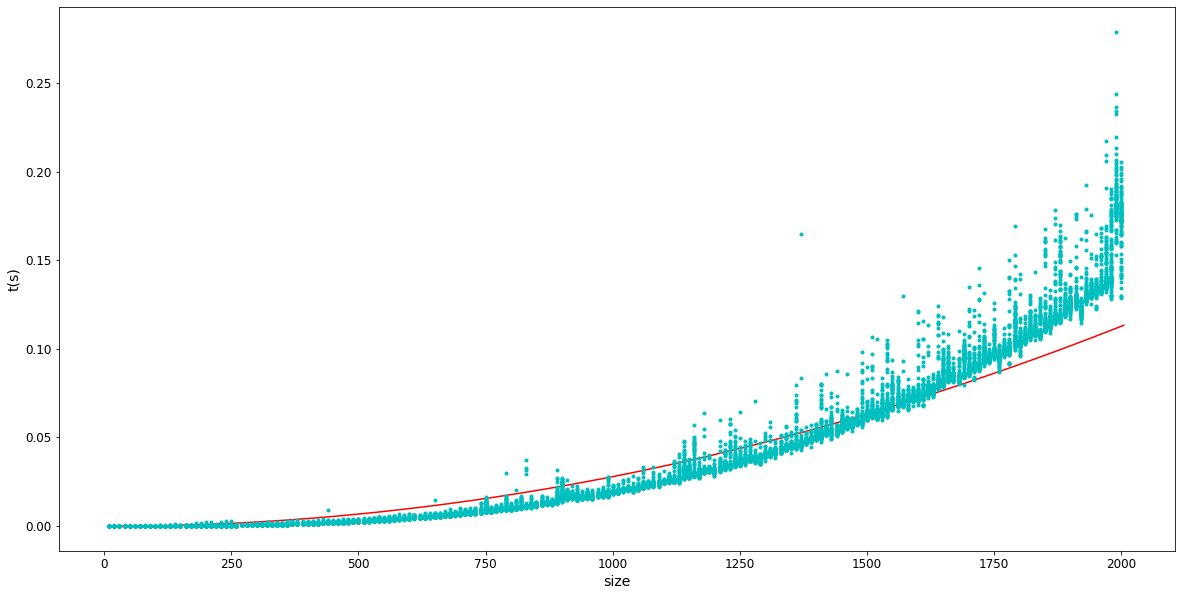

In [47]:
plt.plot(sizes,y,color='r')
plot_quantile_compare1("data/gemm2000.txt")